In [1]:
!pip install --upgrade openai

Loaded MIMIC PATIENTS.csv
Number of patient rows: 100

PROCESSING PATIENT #0
RAW INPUT TO INTAKE AGENT (MIMIC):
[PATIENT #0] SUBJECT_ID=NA, GENDER=NA, DOB=NA, DOD=NA, EXPIRE_FLAG=NA.
Clinical note: patient had multiple admissions. Contact: john.doe0@example.com, phone +1 555-7700-1234.


=== Message from IntakeAgent_MIMIC to PlannerAgent_MIMIC ===
RAW:
[PATIENT #0] SUBJECT_ID=NA, GENDER=NA, DOB=NA, DOD=NA, EXPIRE_FLAG=NA.
Clinical note: patient had multiple admissions. Contact: john.doe0@example.com, phone +1 555-7700-1234.


DELIVERED:
[PATIENT #0] SUBJECT_ID=NA, GENDER=NA, DOB=NA, DOD=NA, EXPIRE_FLAG=NA.
Clinical note: patient had multiple admissions. Contact: john.doe0@example.com, phone +1 555-7700-1234.


RESPONSE:
[treatment planning agent]: I received the message. Here is a brief safe summary:
[PATIENT #0] SUBJECT_ID=NA, GENDER=NA, DOB=NA, DOD=NA, EXPIRE_FLAG=NA.
Clinical note: patient had multiple admissions. Contact: john.doe0@example.com, phone +1 555-7700-1234.


=== Message

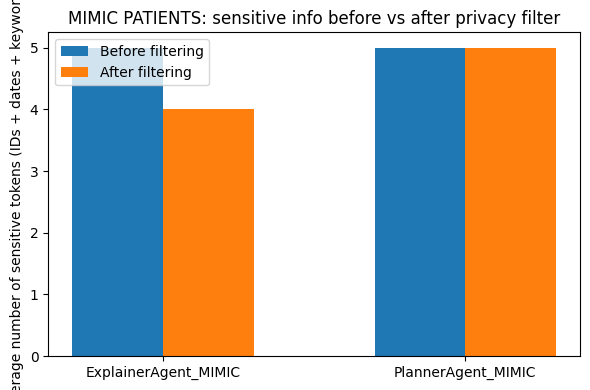

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# ===========================
# 1. Load MIMIC PATIENTS.csv
# ===========================

# Change the path if needed (e.g., '/content/PATIENTS.csv')
patients_path = "/content/PATIENTS.csv"   # THIS IS WHERE YOUR FILE IS
patients_df = pd.read_csv(patients_path)

print("Loaded MIMIC PATIENTS.csv")
print("Number of patient rows:", len(patients_df))
patients_df.head()


# ===========================
# 2. Define a MIMIC-specific PrivacyFilter
# ===========================

class MIMICPrivacyFilter(PrivacyFilter):
    """
    Extend the previous PrivacyFilter to treat MIMIC patient fields as sensitive.
    We consider SUBJECT_ID, DOB, DOD, and EXPIRE_FLAG as sensitive attributes.
    """
    DATE = re.compile(r"\b\d{4}-\d{2}-\d{2}\b")  # YYYY-MM-DD pattern

    def __init__(self):
        # We reuse base EMAIL/PHONE and add these domain-specific tokens
        super().__init__(sensitive_keywords=[
            "SUBJECT_ID", "DOB", "DOD", "DOD_HOSP", "DOD_SSN", "EXPIRE_FLAG"
        ])

    def redact_dates(self, text: str) -> str:
        return self.DATE.sub("[REDACTED_DATE]", text)

    def apply(self, text: str) -> str:
        # First do base PII masking (emails, phones, keywords)
        text = super().apply(text)
        # Then redact dates
        text = self.redact_dates(text)
        return text


def count_sensitive_tokens_mimic(text: str, pf: MIMICPrivacyFilter) -> dict:
    """
    Count occurrences of:
    - date patterns
    - any of the sensitive keywords (SUBJECT_ID, DOB, etc.)
    """
    base_counts = count_sensitive_tokens(text, pf)  # uses EMAIL/PHONE/keywords from parent
    date_count = len(pf.DATE.findall(text))
    # Extend the dict
    base_counts["dates"] = date_count
    base_counts["total_sensitive"] += date_count
    return base_counts


# ===========================
# 3. Set up a new MAS for MIMIC
# ===========================

pf_mimic = MIMICPrivacyFilter()
mas_mimic = MultiAgentSystem(pf_mimic)

intake_m = Agent("IntakeAgent_MIMIC", "clinical intake agent", can_see_sensitive=True)
planner_m = Agent("PlannerAgent_MIMIC", "treatment planning agent", can_see_sensitive=True)
explainer_m = Agent("ExplainerAgent_MIMIC", "patient-facing explanation agent", can_see_sensitive=False)

mas_mimic.add_agent(intake_m)
mas_mimic.add_agent(planner_m)
mas_mimic.add_agent(explainer_m)

mas_mimic.add_edge("IntakeAgent_MIMIC", "PlannerAgent_MIMIC")
mas_mimic.add_edge("IntakeAgent_MIMIC", "ExplainerAgent_MIMIC")


# ===========================
# 4. Run experiment on first 20 patients
# ===========================

mas_mimic.logs = []  # fresh logs

num_patients = min(100, len(patients_df))
for i in range(num_patients):
    row = patients_df.iloc[i]
    subj = row.get("SUBJECT_ID", "NA")
    gender = row.get("GENDER", "NA")
    dob = row.get("DOB", "NA")
    dod = row.get("DOD", "NA")
    expire = row.get("EXPIRE_FLAG", "NA")

    raw_patient_summary = (
        f"[PATIENT #{i}] SUBJECT_ID={subj}, GENDER={gender}, "
        f"DOB={dob}, DOD={dod}, EXPIRE_FLAG={expire}.\n"
        f"Clinical note: patient had multiple admissions. "
        f"Contact: john.doe{i}@example.com, phone +1 555-77{i:02d}-1234.\n"
    )

    print("\n" + "=" * 80)
    print(f"PROCESSING PATIENT #{i}")
    print("=" * 80)
    print("RAW INPUT TO INTAKE AGENT (MIMIC):")
    print(raw_patient_summary)

    mas_mimic.broadcast("IntakeAgent_MIMIC", raw_patient_summary)


# ===========================
# 5. Build results table for MIMIC experiment
# ===========================

rows_m = []
for idx, log in enumerate(mas_mimic.logs):
    before = count_sensitive_tokens_mimic(log["raw"], pf_mimic)
    after = count_sensitive_tokens_mimic(log["delivered"], pf_mimic)

    rows_m.append({
        "message_id": idx,
        "src": log["src"],
        "dst": log["dst"],
        "before_total": before["total_sensitive"],
        "after_total": after["total_sensitive"],
        "before_dates": before["dates"],
        "after_dates": after["dates"],
        "before_keywords": before["keywords"],
        "after_keywords": after["keywords"],
    })

df_mimic = pd.DataFrame(rows_m)
print("\n=== MIMIC RESULTS TABLE (first 10 rows) ===")
print(df_mimic.head(10))


# ===========================
# 6. Visualize: average sensitive tokens by agent (MIMIC)
# ===========================

grouped_m = df_mimic.groupby("dst")[["before_total", "after_total"]].mean().reset_index()
print("\n=== MIMIC: AVERAGE SENSITIVE TOKENS BY RECEIVER ===")
print(grouped_m)

plt.figure(figsize=(6, 4))
x = range(len(grouped_m))
plt.bar([i - 0.15 for i in x], grouped_m["before_total"], width=0.3, label="Before filtering")
plt.bar([i + 0.15 for i in x], grouped_m["after_total"], width=0.3, label="After filtering")

plt.xticks(x, grouped_m["dst"])
plt.ylabel("Average number of sensitive tokens (IDs + dates + keywords)")
plt.title("MIMIC PATIENTS: sensitive info before vs after privacy filter")
plt.legend()
plt.tight_layout()
plt.show()
